### **STEP 1**

In [1]:
# CELL 1: Setup + Load
import os
import re
import sys
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

CSV_PATH = "data/whl_2025.csv"
assert os.path.exists(CSV_PATH), f"CSV not found at {CSV_PATH}"

df_raw = pd.read_csv(CSV_PATH)

print(f"Loaded df_raw shape: {df_raw.shape}")
print("\n=== df_raw.columns ===")
print(list(df_raw.columns))
print("\n=== df_raw.head(3) ===")
display(df_raw.head(3))


Loaded df_raw shape: (25827, 26)

=== df_raw.columns ===
['game_id', 'record_id', 'home_team', 'away_team', 'went_ot', 'home_off_line', 'home_def_pairing', 'away_off_line', 'away_def_pairing', 'home_goalie', 'away_goalie', 'toi', 'home_assists', 'home_shots', 'home_xg', 'home_max_xg', 'home_goals', 'away_assists', 'away_shots', 'away_xg', 'away_max_xg', 'away_goals', 'home_penalties_committed', 'home_penalty_minutes', 'away_penalties_committed', 'away_penalty_minutes']

=== df_raw.head(3) ===


,game_id,record_id,home_team,away_team,went_ot,home_off_line,home_def_pairing,away_off_line,away_def_pairing,home_goalie,away_goalie,toi,home_assists,home_shots,home_xg,home_max_xg,home_goals,away_assists,away_shots,away_xg,away_max_xg,away_goals,home_penalties_committed,home_penalty_minutes,away_penalties_committed,away_penalty_minutes
0,game_1,record_1,thailand,pakistan,0,PP_kill_dwn,PP_kill_dwn,PP_up,PP_up,player_id_142,player_id_106,628.80,0,2,0.1754,0.0877,0,2,9,1.4645,0.2166,1,7,14,1,2
1,game_1,record_2,thailand,pakistan,0,second_off,second_def,second_off,second_def,player_id_142,player_id_106,197.61,0,0,0.0000,0.0000,0,2,1,0.0928,0.0928,1,0,0,0,0
2,game_1,record_3,thailand,pakistan,0,first_off,second_def,second_off,second_def,player_id_142,player_id_106,47.06,0,0,0.0000,0.0000,0,0,2,0.1880,0.0940,0,0,0,0,0


In [2]:
# CELL 2: Column Mapping + Required Columns Check

# ---- EDITABLE COLUMN MAPPING ----
# If auto-detection guesses wrong, edit values here to match your CSV columns exactly.
COLS = {
    "game_id": None,
    "home_team": None,
    "away_team": None,

    "home_off_line": None,
    "away_off_line": None,

    "home_def_pairing": None,
    "away_def_pairing": None,

    "home_goalie": None,
    "away_goalie": None,

    "toi": None,
    "home_xg": None,
    "away_xg": None,
    "home_goals": None,
    "away_goals": None,
}

# ---- Helpers for auto-detection (case-insensitive, punctuation-insensitive) ----
def _norm(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "", str(s).strip().lower())

_norm_cols = {_norm(c): c for c in df_raw.columns}

def _find_first(candidates):
    """Return the first matching original column name based on normalized candidates."""
    for cand in candidates:
        key = _norm(cand)
        if key in _norm_cols:
            return _norm_cols[key]
    return None

# Candidate lists (you can extend if your dataset uses different names)
CANDIDATES = {
    "game_id": [
        "game_id", "gameid", "game", "match_id", "matchid", "id_game", "gamepk"
    ],
    "home_team": [
        "home_team", "hometeam", "home", "homeclub", "home_team_name", "home_team_id"
    ],
    "away_team": [
        "away_team", "awayteam", "away", "visitor", "visiting_team", "away_team_name", "away_team_id"
    ],
    "home_off_line": [
        "home_off_line", "home_offline", "home_off", "home_line_off", "home_offense_line", "home_off_unit"
    ],
    "away_off_line": [
        "away_off_line", "away_offline", "away_off", "away_line_off", "away_offense_line", "away_off_unit"
    ],
    "home_def_pairing": [
        "home_def_pairing", "home_defpairing", "home_def_pair", "home_defpair", "home_def", "home_defense_pair"
    ],
    "away_def_pairing": [
        "away_def_pairing", "away_defpairing", "away_def_pair", "away_defpair", "away_def", "away_defense_pair"
    ],
    "home_goalie": [
        "home_goalie", "home_goalie_id", "homegoalie", "home_g", "home_goalkeeper"
    ],
    "away_goalie": [
        "away_goalie", "away_goalie_id", "awaygoalie", "away_g", "away_goalkeeper"
    ],
    "toi": [
        "toi", "time_on_ice", "timeonice", "seconds", "toi_seconds", "toi_sec"
    ],
    "home_xg": [
        "home_xg", "homexg", "xg_home", "home_expected_goals", "home_xg_sum"
    ],
    "away_xg": [
        "away_xg", "awayxg", "xg_away", "away_expected_goals", "away_xg_sum"
    ],
    "home_goals": [
        "home_goals", "homegoals", "goals_home", "home_gf", "home_goal"
    ],
    "away_goals": [
        "away_goals", "awaygoals", "goals_away", "away_gf", "away_goal"
    ],
}

# Fill mapping if None
for k in COLS:
    if COLS[k] is None:
        COLS[k] = _find_first(CANDIDATES.get(k, []))

# Show mapping
print("=== Final COLS mapping (edit in this cell if needed) ===")
mapping_df = pd.DataFrame(
    {"logical_name": list(COLS.keys()), "csv_column": list(COLS.values())}
)
display(mapping_df)

# Assert required columns exist
REQUIRED_KEYS = ["game_id", "home_team", "away_team", "toi", "home_xg", "away_xg", "home_goals", "away_goals"]
missing_keys = [k for k in REQUIRED_KEYS if not COLS.get(k)]
if missing_keys:
    raise ValueError(
        "Missing required COLS mappings (None). Please edit COLS in CELL 2 for: "
        + ", ".join(missing_keys)
    )

missing_cols = [COLS[k] for k in REQUIRED_KEYS if COLS[k] not in df_raw.columns]
if missing_cols:
    raise ValueError(
        "Missing required columns in df_raw. These mapped columns were not found: "
        + ", ".join(missing_cols)
        + "\nCheck df_raw.columns printed in CELL 1 and edit COLS in CELL 2."
    )

print("\nRequired columns check: PASSED")


=== Final COLS mapping (edit in this cell if needed) ===


,logical_name,csv_column
0,game_id,game_id
1,home_team,home_team
2,away_team,away_team
3,home_off_line,home_off_line
4,away_off_line,away_off_line
5,home_def_pairing,home_def_pairing
6,away_def_pairing,away_def_pairing
7,home_goalie,home_goalie
8,away_goalie,away_goalie
9,toi,toi



Required columns check: PASSED


In [3]:
# CELL 3: Validate game_id consistency (anti-leakage check)

gid = COLS["game_id"]
hteam = COLS["home_team"]
ateam = COLS["away_team"]

# Ensure no accidental whitespace differences
df_chk = df_raw[[gid, hteam, ateam]].copy()
df_chk[hteam] = df_chk[hteam].astype(str).str.strip()
df_chk[ateam] = df_chk[ateam].astype(str).str.strip()

cons = (
    df_chk.groupby(gid, dropna=False)
    .agg(home_team_nunique=(hteam, "nunique"), away_team_nunique=(ateam, "nunique"))
    .reset_index()
)
bad = cons[(cons["home_team_nunique"] > 1) | (cons["away_team_nunique"] > 1)]

if len(bad) > 0:
    print("ERROR: game_id consistency check FAILED. Offending game_ids (showing up to 25):")
    display(bad.head(25))
    raise ValueError("Stopping: Some game_id values map to multiple home/away teams. Fix before proceeding.")

print("game_id consistency check: PASSED")
print(f"Unique games (by {gid}): {df_raw[gid].nunique(dropna=False)}")


game_id consistency check: PASSED
Unique games (by game_id): 1312


In [4]:
# CELL 4: Build Dataset A (GAME-LEVEL TABLE)

# Base sums
toi_col = COLS["toi"]
home_xg_col = COLS["home_xg"]
away_xg_col = COLS["away_xg"]
home_goals_col = COLS["home_goals"]
away_goals_col = COLS["away_goals"]

# Safe detect optional shots/penalties columns (home/away)
def _safe_find_optional_pair(prefix_home, prefix_away, candidates_home, candidates_away):
    """Return (home_col, away_col) if both exist, else (None, None)."""
    hc = _find_first(candidates_home)
    ac = _find_first(candidates_away)
    if hc in df_raw.columns and ac in df_raw.columns:
        return hc, ac
    return None, None

home_shots_col, away_shots_col = _safe_find_optional_pair(
    "home_shots", "away_shots",
    candidates_home=["home_shots", "shots_home", "home_sog", "home_shot", "home_shots_on_goal"],
    candidates_away=["away_shots", "shots_away", "away_sog", "away_shot", "away_shots_on_goal"],
)
home_pim_col, away_pim_col = _safe_find_optional_pair(
    "home_pim", "away_pim",
    candidates_home=["home_pim", "home_penalties", "home_penalty_minutes", "pim_home"],
    candidates_away=["away_pim", "away_penalties", "away_penalty_minutes", "pim_away"],
)

agg_dict = {
    home_goals_col: "sum",
    away_goals_col: "sum",
    home_xg_col: "sum",
    away_xg_col: "sum",
}

if home_shots_col and away_shots_col:
    agg_dict[home_shots_col] = "sum"
    agg_dict[away_shots_col] = "sum"

if home_pim_col and away_pim_col:
    agg_dict[home_pim_col] = "sum"
    agg_dict[away_pim_col] = "sum"

# Keep teams (must be constant per game_id, already validated)
game_level = (
    df_raw.groupby(COLS["game_id"], dropna=False)
    .agg(
        **{
            "home_team": (COLS["home_team"], "first"),
            "away_team": (COLS["away_team"], "first"),
            "home_goals_total": (home_goals_col, "sum"),
            "away_goals_total": (away_goals_col, "sum"),
            "home_xg_total": (home_xg_col, "sum"),
            "away_xg_total": (away_xg_col, "sum"),
        },
        **(
            {
                "home_shots_total": (home_shots_col, "sum"),
                "away_shots_total": (away_shots_col, "sum"),
            } if home_shots_col and away_shots_col else {}
        ),
        **(
            {
                "home_pim_total": (home_pim_col, "sum"),
                "away_pim_total": (away_pim_col, "sum"),
            } if home_pim_col and away_pim_col else {}
        ),
    )
    .reset_index()
)

game_level["home_win"] = (game_level["home_goals_total"] > game_level["away_goals_total"]).astype(int)

print(f"game_level shape: {game_level.shape}")
print("\n=== game_level.head(3) ===")
display(game_level.head(3))
print(f"\nUnique games: {game_level[COLS['game_id']].nunique(dropna=False)}")

OUT_GAME = "data/game_level_step1.csv"
game_level.to_csv(OUT_GAME, index=False)
print(f"\nSaved: {OUT_GAME}")


game_level shape: (1312, 12)

=== game_level.head(3) ===


,game_id,home_team,away_team,home_goals_total,away_goals_total,home_xg_total,away_xg_total,home_shots_total,away_shots_total,home_pim_total,away_pim_total,home_win
0,game_1,thailand,pakistan,1,3,2.8231,2.7516,21,24,16,12,0
1,game_10,switzerland,kazakhstan,4,3,1.9254,3.3189,20,30,20,0,1
2,game_100,serbia,rwanda,4,5,3.6712,3.0240,30,27,16,20,0



Unique games: 1312

Saved: data/game_level_step1.csv


In [5]:
# CELL 5: Build Dataset B (LONG TABLE: 2 rows per original row)

# Optional columns may be None; handle gracefully
def _col_or_na(colname):
    return colname if (colname is not None and colname in df_raw.columns) else None

home_off_line_col = _col_or_na(COLS["home_off_line"])
away_off_line_col = _col_or_na(COLS["away_off_line"])
home_def_pair_col = _col_or_na(COLS["home_def_pairing"])
away_def_pair_col = _col_or_na(COLS["away_def_pairing"])
home_goalie_col = _col_or_na(COLS["home_goalie"])
away_goalie_col = _col_or_na(COLS["away_goalie"])

# Required cols already checked; proceed
base_cols = [COLS["game_id"], COLS["home_team"], COLS["away_team"], COLS["toi"],
             COLS["home_xg"], COLS["away_xg"], COLS["home_goals"], COLS["away_goals"]]

optional_in = []
for c in [home_off_line_col, away_off_line_col, home_def_pair_col, away_def_pair_col, home_goalie_col, away_goalie_col]:
    if c is not None:
        optional_in.append(c)

use_cols = list(dict.fromkeys(base_cols + optional_in))
df_use = df_raw[use_cols].copy()

# Home observation
home_obs = pd.DataFrame({
    "game_id": df_use[COLS["game_id"]],
    "team": df_use[COLS["home_team"]].astype(str).str.strip(),
    "opp": df_use[COLS["away_team"]].astype(str).str.strip(),
    "off_line": df_use[home_off_line_col] if home_off_line_col else pd.Series([np.nan] * len(df_use)),
    "def_pair_opp": df_use[away_def_pair_col] if away_def_pair_col else pd.Series([np.nan] * len(df_use)),
    "goalie_opp": df_use[away_goalie_col] if away_goalie_col else pd.Series([np.nan] * len(df_use)),
    "toi": pd.to_numeric(df_use[COLS["toi"]], errors="coerce"),
    "xg_for": pd.to_numeric(df_use[COLS["home_xg"]], errors="coerce"),
    "goals_for": pd.to_numeric(df_use[COLS["home_goals"]], errors="coerce"),
    "is_home": 1
})

# Away observation (mirrored)
away_obs = pd.DataFrame({
    "game_id": df_use[COLS["game_id"]],
    "team": df_use[COLS["away_team"]].astype(str).str.strip(),
    "opp": df_use[COLS["home_team"]].astype(str).str.strip(),
    "off_line": df_use[away_off_line_col] if away_off_line_col else pd.Series([np.nan] * len(df_use)),
    "def_pair_opp": df_use[home_def_pair_col] if home_def_pair_col else pd.Series([np.nan] * len(df_use)),
    "goalie_opp": df_use[home_goalie_col] if home_goalie_col else pd.Series([np.nan] * len(df_use)),
    "toi": pd.to_numeric(df_use[COLS["toi"]], errors="coerce"),
    "xg_for": pd.to_numeric(df_use[COLS["away_xg"]], errors="coerce"),
    "goals_for": pd.to_numeric(df_use[COLS["away_goals"]], errors="coerce"),
    "is_home": 0
})

long_df = pd.concat([home_obs, away_obs], ignore_index=True)

print(f"long_df shape: {long_df.shape}")
print("\n=== long_df.head(3) ===")
display(long_df.head(3))

# Sanity stats
key_fields = ["team", "opp", "off_line", "def_pair_opp", "goalie_opp", "toi", "xg_for", "goals_for", "is_home", "game_id"]
miss_pct = (long_df[key_fields].isna().mean() * 100).sort_values(ascending=False)

print("\n=== Sanity stats ===")
print(f"toi min/max: {np.nanmin(long_df['toi'].values):.6g} / {np.nanmax(long_df['toi'].values):.6g}")
print(f"xg_for min/max: {np.nanmin(long_df['xg_for'].values):.6g} / {np.nanmax(long_df['xg_for'].values):.6g}")
print("\n% missing by key field:")
display(miss_pct.to_frame("missing_%"))

OUT_LONG = "data/long_table_step1.csv"
long_df.to_csv(OUT_LONG, index=False)
print(f"\nSaved: {OUT_LONG}")


long_df shape: (51654, 10)

=== long_df.head(3) ===


,game_id,team,opp,off_line,def_pair_opp,goalie_opp,toi,xg_for,goals_for,is_home
0,game_1,thailand,pakistan,PP_kill_dwn,PP_up,player_id_106,628.80,0.1754,0,1
1,game_1,thailand,pakistan,second_off,second_def,player_id_106,197.61,0.0000,0,1
2,game_1,thailand,pakistan,first_off,second_def,player_id_106,47.06,0.0000,0,1



=== Sanity stats ===
toi min/max: 0.01 / 1559.67
xg_for min/max: 0 / 5.5435

% missing by key field:


,missing_%
team,0.0
opp,0.0
off_line,0.0
def_pair_opp,0.0
goalie_opp,0.0
toi,0.0
xg_for,0.0
goals_for,0.0
is_home,0.0
game_id,0.0



Saved: data/long_table_step1.csv


In [6]:
# CELL 6: print

print("SECTION 1 COMPLETE ✅")
print("Saved files:")
print(f" - {OUT_GAME}")
print(f" - {OUT_LONG}")


SECTION 1 COMPLETE ✅
Saved files:
 - data/game_level_step1.csv
 - data/long_table_step1.csv


### ***STEP2***

In [7]:
# CELL 1: Load long_table_step1.csv
import os
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

LONG_PATH = "data/long_table_step1.csv"
assert os.path.exists(LONG_PATH), f"Missing required file: {LONG_PATH}"

long_df = pd.read_csv(LONG_PATH)

print(f"Loaded long_df shape: {long_df.shape}")
print("Columns:", list(long_df.columns))
display(long_df.head(3))

Loaded long_df shape: (51654, 10)
Columns: ['game_id', 'team', 'opp', 'off_line', 'def_pair_opp', 'goalie_opp', 'toi', 'xg_for', 'goals_for', 'is_home']


,game_id,team,opp,off_line,def_pair_opp,goalie_opp,toi,xg_for,goals_for,is_home
0,game_1,thailand,pakistan,PP_kill_dwn,PP_up,player_id_106,628.80,0.1754,0,1
1,game_1,thailand,pakistan,second_off,second_def,player_id_106,197.61,0.0000,0,1
2,game_1,thailand,pakistan,first_off,second_def,player_id_106,47.06,0.0000,0,1


In [8]:
# CELL 2: Basic cleaning (toi > 0, toi not missing, xg_for not missing)
required_cols = ["team", "opp", "off_line", "def_pair_opp", "goalie_opp", "toi", "xg_for", "goals_for", "is_home"]
missing = [c for c in required_cols if c not in long_df.columns]
if missing:
    raise ValueError(f"Missing required columns in long_df: {missing}")

before_n = len(long_df)

# Coerce numeric
long_df["toi"] = pd.to_numeric(long_df["toi"], errors="coerce")
long_df["xg_for"] = pd.to_numeric(long_df["xg_for"], errors="coerce")

# Drop invalid rows
mask_keep = long_df["toi"].notna() & (long_df["toi"] > 0) & long_df["xg_for"].notna()
removed_n = before_n - mask_keep.sum()

long_df = long_df.loc[mask_keep].copy()
after_n = len(long_df)

print(f"Rows before cleaning: {before_n:,}")
print(f"Rows removed (toi<=0 or missing, or xg_for missing): {removed_n:,}")
print(f"Rows after cleaning:  {after_n:,}")
print("\nSanity: toi min/max:", long_df["toi"].min(), long_df["toi"].max())
print("Sanity: xg_for min/max:", long_df["xg_for"].min(), long_df["xg_for"].max())


Rows before cleaning: 51,654
Rows removed (toi<=0 or missing, or xg_for missing): 0
Rows after cleaning:  51,654

Sanity: toi min/max: 0.01 1559.67
Sanity: xg_for min/max: 0.0 5.5435


In [9]:
# CELL 3: Filter to EVEN STRENGTH ONLY (first_off, second_off)
EV_LINES = ["first_off", "second_off"]

before_ev = len(long_df)
ev_df = long_df[long_df["off_line"].astype(str).str.strip().isin(EV_LINES)].copy()
after_ev = len(ev_df)

print(f"Rows before EV filter: {before_ev:,}")
print(f"Rows after EV filter:  {after_ev:,}")
print("\nCounts by off_line retained:")
display(ev_df["off_line"].value_counts(dropna=False).to_frame("count"))


Rows before EV filter: 51,654
Rows after EV filter:  43,995

Counts by off_line retained:


,count
off_line,
second_off,21998
first_off,21997


In [10]:
# CELL 4: Compute raw TOI-weighted offensive performance by (team, off_line)
grp = ev_df.groupby(["team", "off_line"], dropna=False)

line_perf_raw = (
    grp.agg(
        total_xg=("xg_for", "sum"),
        total_toi=("toi", "sum"),
    )
    .reset_index()
)

line_perf_raw["xg_per60"] = (line_perf_raw["total_xg"] / line_perf_raw["total_toi"]) * 3600.0

print(f"line_perf_raw shape: {line_perf_raw.shape}")
display(line_perf_raw.sort_values(["team", "off_line"]).head(10))


line_perf_raw shape: (64, 5)


,team,off_line,total_xg,total_toi,xg_per60
0,brazil,first_off,81.0273,108743.00,2.682456
1,brazil,second_off,81.7372,107499.01,2.737271
2,canada,first_off,74.0168,112738.79,2.363521
3,canada,second_off,70.4763,108486.72,2.338670
4,china,first_off,79.6366,114861.38,2.495980
5,china,second_off,74.2364,112620.31,2.373027
6,ethiopia,first_off,68.1714,110562.04,2.219722
7,ethiopia,second_off,72.6759,106755.99,2.450759
8,france,first_off,79.1799,112104.22,2.542702
9,france,second_off,58.2622,110535.24,1.897530


In [11]:
# CELL 5: Minimum TOI filter for stability
MIN_TOI = 600 * 60  # 600 minutes in seconds

before_pairs = len(line_perf_raw)
line_perf_filt = line_perf_raw[line_perf_raw["total_toi"] >= MIN_TOI].copy()
after_pairs = len(line_perf_filt)

print(f"MIN_TOI (seconds): {MIN_TOI:,}")
print(f"(team, off_line) pairs before TOI filter: {before_pairs:,}")
print(f"(team, off_line) pairs after TOI filter:  {after_pairs:,}")
print(f"Pairs removed: {before_pairs - after_pairs:,}")

print("\nRemaining off_line counts:")
display(line_perf_filt["off_line"].value_counts().to_frame("count"))


MIN_TOI (seconds): 36,000
(team, off_line) pairs before TOI filter: 64
(team, off_line) pairs after TOI filter:  64
Pairs removed: 0

Remaining off_line counts:


,count
off_line,
first_off,32
second_off,32


In [12]:
# CELL 6: Pivot to team-level wide format (first_line_xg60, second_line_xg60)
wide = (
    line_perf_filt.pivot_table(
        index="team",
        columns="off_line",
        values="xg_per60",
        aggfunc="first",
    )
    .rename(columns={
        "first_off": "first_line_xg60",
        "second_off": "second_line_xg60",
    })
    .reset_index()
)

print(f"wide shape (teams with any retained line): {wide.shape}")
display(wide.head(5))

missing_first = wide["first_line_xg60"].isna().sum()
missing_second = wide["second_line_xg60"].isna().sum()
print(f"Teams missing first_line_xg60:  {missing_first}")
print(f"Teams missing second_line_xg60: {missing_second}")


wide shape (teams with any retained line): (32, 3)


off_line,team,first_line_xg60,second_line_xg60
0,brazil,2.682456,2.737271
1,canada,2.363521,2.338670
2,china,2.495980,2.373027
3,ethiopia,2.219722,2.450759
4,france,2.542702,1.897530


Teams missing first_line_xg60:  0
Teams missing second_line_xg60: 0


In [13]:
# CELL 7: Compute disparity ratio + diff (and check division by zero)
disparity_table = wide.copy()

# Division-by-zero / near-zero checks
zero_or_nan_second = (disparity_table["second_line_xg60"].isna()) | (disparity_table["second_line_xg60"] == 0)
print(f"Teams with second_line_xg60 == 0 or NaN: {zero_or_nan_second.sum()}")

disparity_table["disparity_ratio"] = disparity_table["first_line_xg60"] / disparity_table["second_line_xg60"]
disparity_table["disparity_diff"] = disparity_table["first_line_xg60"] - disparity_table["second_line_xg60"]

# Replace inf with NaN for clean sorting/stats
disparity_table.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop teams where either line is missing after TOI filter (needed for ratio)
before_drop = len(disparity_table)
disparity_table = disparity_table.dropna(subset=["first_line_xg60", "second_line_xg60", "disparity_ratio"]).copy()
after_drop = len(disparity_table)
print(f"Teams before dropping missing lines: {before_drop}")
print(f"Teams after dropping missing lines:  {after_drop}")


Teams with second_line_xg60 == 0 or NaN: 0
Teams before dropping missing lines: 32
Teams after dropping missing lines:  32


In [14]:
# CELL 8: Sort descending by disparity_ratio
disparity_table_sorted = disparity_table.sort_values("disparity_ratio", ascending=False).reset_index(drop=True)

print(f"disparity_table_sorted shape: {disparity_table_sorted.shape}")
display(disparity_table_sorted.head(10))


disparity_table_sorted shape: (32, 5)


off_line,team,first_line_xg60,second_line_xg60,disparity_ratio,disparity_diff
0,usa,2.722108,1.995230,1.364308,0.726878
1,saudi_arabia,2.230361,1.636620,1.362785,0.593742
2,guatemala,2.787262,2.056095,1.355610,0.731167
3,uae,1.982444,1.462816,1.355225,0.519628
4,france,2.542702,1.897530,1.340006,0.645172
5,iceland,2.574164,1.944120,1.324077,0.630045
6,singapore,2.614200,2.083017,1.255006,0.531182
7,new_zealand,2.417589,1.973352,1.225118,0.444237
8,panama,2.531816,2.111680,1.198958,0.420136
9,peru,2.372764,1.980904,1.197819,0.391860


In [15]:
# CELL 9: Print Top 10, summary stats, division-by-zero check
print("=== TOP 10 TEAMS BY DISPARITY RATIO ===")
display(disparity_table_sorted.head(10)[
    ["team", "first_line_xg60", "second_line_xg60", "disparity_ratio", "disparity_diff"]
])

print("\n=== SUMMARY STATS: disparity_ratio ===")
display(disparity_table_sorted["disparity_ratio"].describe().to_frame().T)

# Extra checks
min_second = disparity_table_sorted["second_line_xg60"].min()
print(f"\nSanity: min second_line_xg60 among retained teams: {min_second}")
if min_second <= 0:
    print("WARNING: Found non-positive second_line_xg60 after filtering; check data.")



=== TOP 10 TEAMS BY DISPARITY RATIO ===


off_line,team,first_line_xg60,second_line_xg60,disparity_ratio,disparity_diff
0,usa,2.722108,1.995230,1.364308,0.726878
1,saudi_arabia,2.230361,1.636620,1.362785,0.593742
2,guatemala,2.787262,2.056095,1.355610,0.731167
3,uae,1.982444,1.462816,1.355225,0.519628
4,france,2.542702,1.897530,1.340006,0.645172
5,iceland,2.574164,1.944120,1.324077,0.630045
6,singapore,2.614200,2.083017,1.255006,0.531182
7,new_zealand,2.417589,1.973352,1.225118,0.444237
8,panama,2.531816,2.111680,1.198958,0.420136
9,peru,2.372764,1.980904,1.197819,0.391860



=== SUMMARY STATS: disparity_ratio ===


,count,mean,std,min,25%,50%,75%,max
disparity_ratio,32.0,1.113563,0.1489,0.888955,0.99484,1.082869,1.205498,1.364308



Sanity: min second_line_xg60 among retained teams: 1.4628155679522878


In [16]:
# CELL 10: Save results
OUT_PATH = "data/line_disparity_section2.csv"
disparity_table_sorted.to_csv(OUT_PATH, index=False)

print(f"Saved: {OUT_PATH}")
print("Section 2 complete ✅")


Saved: data/line_disparity_section2.csv
Section 2 complete ✅


### ***STEP 3***

In [17]:
# CELL 1: STEP 3 — Filter + clean modeling data (use long_df already in memory)

import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor

# Ensure required upstream variables exist
assert "long_df" in globals(), "long_df not found in memory. Run Sections 1–2 above first."
assert "disparity_table_sorted" in globals(), "disparity_table_sorted not found in memory. Run Section 2 above first."

REQ_COLS = ["team","opp","off_line","def_pair_opp","goalie_opp","toi","xg_for","goals_for","is_home"]
missing_cols = [c for c in REQ_COLS if c not in long_df.columns]
if missing_cols:
    raise ValueError(f"long_df missing required columns for Step 3: {missing_cols}")

EV_LINES = ["first_off", "second_off"]

model_df = long_df.copy()

# Normalize key strings lightly (no guessing)
model_df["team"] = model_df["team"].astype(str).str.strip()
model_df["opp"] = model_df["opp"].astype(str).str.strip()
model_df["off_line"] = model_df["off_line"].astype(str).str.strip()
model_df["def_pair_opp"] = model_df["def_pair_opp"].where(model_df["def_pair_opp"].notna(), "__MISSING__")
model_df["def_pair_opp"] = model_df["def_pair_opp"].astype(str).str.strip()
model_df["goalie_opp"] = model_df["goalie_opp"].where(model_df["goalie_opp"].notna(), "__MISSING__")
model_df["goalie_opp"] = model_df["goalie_opp"].astype(str).str.strip()

# Filter to even-strength lines only
before_lines = len(model_df)
model_df = model_df[model_df["off_line"].isin(EV_LINES)].copy()
after_lines = len(model_df)

# Numeric coercion
model_df["toi"] = pd.to_numeric(model_df["toi"], errors="coerce")
model_df["xg_for"] = pd.to_numeric(model_df["xg_for"], errors="coerce")
model_df["is_home"] = pd.to_numeric(model_df["is_home"], errors="coerce").fillna(0).astype(int)

# Drop rows with toi <= 0 or missing, or missing xg_for
before_clean = len(model_df)
keep = model_df["toi"].notna() & (model_df["toi"] > 0) & model_df["xg_for"].notna()
removed = before_clean - keep.sum()
model_df = model_df.loc[keep].copy()
after_clean = len(model_df)

print(f"Rows before line filter: {before_lines:,}")
print(f"Rows after line filter (first_off/second_off): {after_lines:,}")
print(f"Rows before numeric clean: {before_clean:,}")
print(f"Rows removed (toi<=0/missing or xg_for missing): {removed:,}")
print(f"Rows after clean: {after_clean:,}")

print("\nCounts by off_line:")
display(model_df["off_line"].value_counts(dropna=False).to_frame("count"))

print("\nSanity: toi min/max:", float(model_df["toi"].min()), "/", float(model_df["toi"].max()))
print("Sanity: xg_for min/max:", float(model_df["xg_for"].min()), "/", float(model_df["xg_for"].max()))
print("Sanity: % missing def_pair_opp:", round(model_df["def_pair_opp"].isna().mean() * 100, 4))
print("Sanity: % missing goalie_opp:", round(model_df["goalie_opp"].isna().mean() * 100, 4))


Rows before line filter: 51,654
Rows after line filter (first_off/second_off): 43,995
Rows before numeric clean: 43,995
Rows removed (toi<=0/missing or xg_for missing): 0
Rows after clean: 43,995

Counts by off_line:


,count
off_line,
second_off,21998
first_off,21997



Sanity: toi min/max: 0.01 / 598.36
Sanity: xg_for min/max: 0.0 / 1.3481
Sanity: % missing def_pair_opp: 0.0
Sanity: % missing goalie_opp: 0.0


In [18]:
# CELL 2: Prepare features + exposure handling (offset via rate + sample_weight)

# Feature engineering per requirements
model_df["team_offline"] = model_df["team"] + "_" + model_df["off_line"]

# Target / exposure
y_xg = model_df["xg_for"].to_numpy(dtype=float)
toi = model_df["toi"].to_numpy(dtype=float)

# Poisson exposure handling:
# Model xg rate (xg per second) with sample_weight = toi
y_rate = y_xg / toi
sample_weight = toi

if np.any(y_rate < 0):
    bad_n = int(np.sum(y_rate < 0))
    raise ValueError(f"Found {bad_n} negative y_rate values. Check xg_for/toi cleaning.")

X = model_df[["team_offline", "def_pair_opp", "goalie_opp", "is_home"]].copy()

# Choose baseline (dropped) categories explicitly (most frequent) — not silent
baseline_team_offline = model_df["team_offline"].value_counts().index[0]
baseline_def_pair = model_df["def_pair_opp"].value_counts().index[0]
baseline_goalie = model_df["goalie_opp"].value_counts().index[0]
DROP_CATS = [baseline_team_offline, baseline_def_pair, baseline_goalie]

print("Baseline categories (dropped to avoid dummy trap):")
print(" - team_offline baseline:", baseline_team_offline)
print(" - def_pair_opp baseline:", baseline_def_pair)
print(" - goalie_opp baseline:", baseline_goalie)

# One-hot encode categorical features with one category dropped per group
try:
    ohe = OneHotEncoder(drop=DROP_CATS, handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(drop=DROP_CATS, handle_unknown="ignore", sparse=True)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, ["team_offline", "def_pair_opp", "goalie_opp"]),
        ("num", "passthrough", ["is_home"]),
    ],
    remainder="drop",
)

ALPHA = 0.1       # non-zero regularization strength (edit if needed)
MAX_ITER = 2000   # increase if convergence issues
TOL = 1e-7

poisson = PoissonRegressor(alpha=ALPHA, fit_intercept=True, max_iter=MAX_ITER, tol=TOL)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", poisson),
])

print("\nDesign matrix will be created with one-hot encoding + is_home passthrough.")
print(f"Training rows: {len(model_df):,}")
print(f"Unique team_offline: {model_df['team_offline'].nunique():,}")
print(f"Unique def_pair_opp: {model_df['def_pair_opp'].nunique():,}")
print(f"Unique goalie_opp: {model_df['goalie_opp'].nunique():,}")


Baseline categories (dropped to avoid dummy trap):
 - team_offline baseline: brazil_second_off
 - def_pair_opp baseline: second_def
 - goalie_opp baseline: empty_net

Design matrix will be created with one-hot encoding + is_home passthrough.
Training rows: 43,995
Unique team_offline: 64
Unique def_pair_opp: 3
Unique goalie_opp: 33


In [19]:
# CELL 3: Fit regularized Poisson regression + print convergence + feature count

pipe.fit(X, y_rate, model__sample_weight=sample_weight)

fitted_model = pipe.named_steps["model"]
fitted_pre = pipe.named_steps["preprocess"]

# Convergence status
n_iter = getattr(fitted_model, "n_iter_", None)
print("\n=== Model fit status ===")
print("Alpha (L2):", ALPHA)
print("Max iter:", MAX_ITER)
print("Tol:", TOL)
print("n_iter_:", n_iter)

if n_iter is not None:
    if n_iter >= MAX_ITER:
        print("WARNING: Reached max_iter; may not have fully converged.")
    else:
        print("Convergence: OK (n_iter_ < max_iter)")

# Feature count
feature_names = fitted_pre.get_feature_names_out()
print("\nNumber of encoded features:", len(feature_names))

# Optional training diagnostics (sanity only)
train_mu_rate = pipe.predict(X)
print("Predicted rate (per sec) min/mean/max:",
      float(np.min(train_mu_rate)), "/", float(np.mean(train_mu_rate)), "/", float(np.max(train_mu_rate)))



=== Model fit status ===
Alpha (L2): 0.1
Max iter: 2000
Tol: 1e-07
n_iter_: 1
Convergence: OK (n_iter_ < max_iter)

Number of encoded features: 98
Predicted rate (per sec) min/mean/max: 0.0006240390566547587 / 0.0006241581313231634 / 0.0006242743657530553


In [20]:
# CELL 4: Extract team_offline coefficients -> adjusted_xg60; pivot wide; compute adjusted ratios

coef = fitted_model.coef_
intercept = float(fitted_model.intercept_)

coef_by_feature = pd.Series(coef, index=feature_names)

# Map coefficients for team_offline dummies
TEAM_PREFIX = "cat__team_offline_"
team_coef_map = {}
for fname, c in coef_by_feature.items():
    if fname.startswith(TEAM_PREFIX):
        cat = fname[len(TEAM_PREFIX):]
        team_coef_map[cat] = float(c)

# Ensure baseline category exists with coef 0
team_offline_all = sorted(model_df["team_offline"].unique().tolist())
if baseline_team_offline not in team_offline_all:
    raise ValueError("Baseline team_offline not found in model_df categories — unexpected.")

rows = []
for cat in team_offline_all:
    beta = team_coef_map.get(cat, 0.0)  # baseline (dropped) -> 0.0

    # Baseline opponent + baseline goalie + is_home=0 => only intercept + beta(team_offline)
    rate_per_sec = float(np.exp(intercept + beta))
    adjusted_xg60 = rate_per_sec * 3600.0

    if cat.endswith("_first_off"):
        team = cat[:-len("_first_off")]
        off_line = "first_off"
    elif cat.endswith("_second_off"):
        team = cat[:-len("_second_off")]
        off_line = "second_off"
    else:
        # Fallback: last underscore split (shouldn't trigger with required off_line values)
        team, off_line = cat.rsplit("_", 1)

    rows.append({
        "team": team,
        "off_line": off_line,
        "team_offline": cat,
        "beta_team_offline": beta,
        "adjusted_xg60": adjusted_xg60,
    })

adj_line_df = pd.DataFrame(rows)

print(f"adj_line_df shape: {adj_line_df.shape}")
display(adj_line_df.head(6))

# Pivot to wide
adj_wide = (
    adj_line_df.pivot_table(index="team", columns="off_line", values="adjusted_xg60", aggfunc="first")
    .rename(columns={"first_off": "first_line_adj_xg60", "second_off": "second_line_adj_xg60"})
    .reset_index()
)

# Compute adjusted ratio/diff
adj_wide["adjusted_ratio"] = adj_wide["first_line_adj_xg60"] / adj_wide["second_line_adj_xg60"]
adj_wide["adjusted_diff"]  = adj_wide["first_line_adj_xg60"] - adj_wide["second_line_adj_xg60"]

# Clean infinities if any
adj_wide.replace([np.inf, -np.inf], np.nan, inplace=True)

# Division-by-zero check
zero_second = (adj_wide["second_line_adj_xg60"].isna()) | (adj_wide["second_line_adj_xg60"] <= 0)
print("Teams with second_line_adj_xg60 <= 0 or NaN:", int(zero_second.sum()))


adj_line_df shape: (64, 5)


,team,off_line,team_offline,beta_team_offline,adjusted_xg60
0,brazil,first_off,brazil_first_off,0.000019,2.246970
1,brazil,second_off,brazil_second_off,0.000000,2.246929
2,canada,first_off,canada_first_off,0.000005,2.246940
3,canada,second_off,canada_second_off,0.000004,2.246937
4,china,first_off,china_first_off,0.000011,2.246954
5,china,second_off,china_second_off,0.000006,2.246941


Teams with second_line_adj_xg60 <= 0 or NaN: 0


In [21]:
# CELL 5: Merge with raw disparity_table_sorted; compare; print top 10 adjusted; save CSV

# Raw table is already sorted by raw disparity_ratio (Section 2)
raw_cols_needed = ["team", "disparity_ratio", "disparity_diff"]
missing_raw = [c for c in raw_cols_needed if c not in disparity_table_sorted.columns]
if missing_raw:
    raise ValueError(f"disparity_table_sorted missing expected columns: {missing_raw}")

compare_df = disparity_table_sorted.merge(
    adj_wide[["team", "first_line_adj_xg60", "second_line_adj_xg60", "adjusted_ratio", "adjusted_diff"]],
    on="team",
    how="left",
)

compare_df = compare_df.rename(columns={
    "disparity_ratio": "raw_ratio",
    "disparity_diff": "raw_diff",
})

# Sort by adjusted ratio for reporting
compare_sorted = compare_df.sort_values("adjusted_ratio", ascending=False).reset_index(drop=True)

print("=== Comparison (raw vs adjusted) — top rows ===")
display(compare_sorted.head(10)[
    ["team", "raw_ratio", "adjusted_ratio", "raw_diff", "adjusted_diff",
     "first_line_adj_xg60", "second_line_adj_xg60"]
])

print("\n=== TOP 10 TEAMS BY adjusted_ratio ===")
display(compare_sorted.head(10)[
    ["team", "first_line_adj_xg60", "second_line_adj_xg60", "adjusted_ratio", "adjusted_diff", "raw_ratio"]
])

print("\n=== Summary stats: adjusted_ratio ===")
display(compare_sorted["adjusted_ratio"].describe().to_frame().T)

# Correlation sanity (where both available)
valid_corr = compare_sorted[["raw_ratio", "adjusted_ratio"]].dropna()
if len(valid_corr) >= 3:
    print("\nCorrelation(raw_ratio, adjusted_ratio):", float(valid_corr.corr().iloc[0,1]))
else:
    print("\nNot enough non-missing pairs to compute correlation.")

# Extreme values warning
extreme_thresh = 3.0
extreme = compare_sorted[compare_sorted["adjusted_ratio"] > extreme_thresh]
if len(extreme) > 0:
    print(f"\nWARNING: {len(extreme)} teams have adjusted_ratio > {extreme_thresh}. Inspect for stability:")
    display(extreme[["team", "first_line_adj_xg60", "second_line_adj_xg60", "adjusted_ratio"]].head(15))

# Save
OUT_PATH = "data/line_disparity_section3_adjusted.csv"
compare_sorted.to_csv(OUT_PATH, index=False)
print(f"\nSaved: {OUT_PATH}")
print("STEP 3 complete ")


=== Comparison (raw vs adjusted) — top rows ===


off_line,team,raw_ratio,adjusted_ratio,raw_diff,adjusted_diff,first_line_adj_xg60,second_line_adj_xg60
0,guatemala,1.355610,1.000031,0.731167,0.000071,2.246981,2.246910
1,usa,1.364308,1.000030,0.726878,0.000068,2.246974,2.246905
2,france,1.340006,1.000028,0.645172,0.000063,2.246958,2.246895
3,iceland,1.324077,1.000027,0.630045,0.000060,2.246960,2.246900
4,saudi_arabia,1.362785,1.000026,0.593742,0.000059,2.246927,2.246868
5,singapore,1.255006,1.000023,0.531182,0.000052,2.246965,2.246913
6,uae,1.355225,1.000023,0.519628,0.000051,2.246902,2.246851
7,new_zealand,1.225118,1.000019,0.444237,0.000042,2.246945,2.246903
8,brazil,0.979974,1.000019,-0.054815,0.000042,2.246970,2.246929
9,panama,1.198958,1.000018,0.420136,0.000041,2.246957,2.246915



=== TOP 10 TEAMS BY adjusted_ratio ===


off_line,team,first_line_adj_xg60,second_line_adj_xg60,adjusted_ratio,adjusted_diff,raw_ratio
0,guatemala,2.246981,2.246910,1.000031,0.000071,1.355610
1,usa,2.246974,2.246905,1.000030,0.000068,1.364308
2,france,2.246958,2.246895,1.000028,0.000063,1.340006
3,iceland,2.246960,2.246900,1.000027,0.000060,1.324077
4,saudi_arabia,2.246927,2.246868,1.000026,0.000059,1.362785
5,singapore,2.246965,2.246913,1.000023,0.000052,1.255006
6,uae,2.246902,2.246851,1.000023,0.000051,1.355225
7,new_zealand,2.246945,2.246903,1.000019,0.000042,1.225118
8,brazil,2.246970,2.246929,1.000019,0.000042,0.979974
9,panama,2.246957,2.246915,1.000018,0.000041,1.198958



=== Summary stats: adjusted_ratio ===


,count,mean,std,min,25%,50%,75%,max
adjusted_ratio,32.0,1.00001,0.000012,0.99999,1.0,1.00001,1.000019,1.000031



Correlation(raw_ratio, adjusted_ratio): 0.9459391337749865

Saved: data/line_disparity_section3_adjusted.csv
STEP 3 complete 


### **STEP 4**

In [22]:
# CELL 1: SECTION 4 — Filter + derive situation (use long_df in memory)

import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor

assert "long_df" in globals(), "long_df not found in memory. Run Sections 1–3 first."

REQ_COLS = ["team","off_line","goalie_opp","xg_for","goals_for","is_home"]
missing = [c for c in REQ_COLS if c not in long_df.columns]
if missing:
    raise ValueError(f"long_df missing required columns for Section 4: {missing}")

finish_df = long_df.copy()

# Normalize strings
finish_df["team"] = finish_df["team"].astype(str).str.strip()
finish_df["off_line"] = finish_df["off_line"].astype(str).str.strip()
finish_df["goalie_opp"] = finish_df["goalie_opp"].where(finish_df["goalie_opp"].notna(), "__MISSING__")
finish_df["goalie_opp"] = finish_df["goalie_opp"].astype(str).str.strip()

# Coerce numerics
finish_df["xg_for"] = pd.to_numeric(finish_df["xg_for"], errors="coerce")
finish_df["goals_for"] = pd.to_numeric(finish_df["goals_for"], errors="coerce")
finish_df["is_home"] = pd.to_numeric(finish_df["is_home"], errors="coerce").fillna(0).astype(int)

print("Unique off_line values (top 25):")
display(finish_df["off_line"].value_counts(dropna=False).head(25).to_frame("count"))

# Situation mapping (edit if your dataset uses different labels)
OFFLINE_TO_SITUATION = {
    "first_off": "EV",
    "second_off": "EV",
    "PP_up": "PP",
    # anything else -> OTHER (excluded)
}

finish_df["situation"] = finish_df["off_line"].map(OFFLINE_TO_SITUATION).fillna("OTHER")

# Filter per requirements
before_n = len(finish_df)

# Drop xg_for <= 0 or missing
mask_xg = finish_df["xg_for"].notna() & (finish_df["xg_for"] > 0)

# Drop missing goals_for
mask_goals = finish_df["goals_for"].notna()

# Keep only EV + PP (exclude empty net and others)
mask_sit = finish_df["situation"].isin(["EV", "PP"])

finish_df = finish_df[mask_xg & mask_goals & mask_sit].copy()
after_n = len(finish_df)

print(f"\nRows before filtering: {before_n:,}")
print(f"Rows after filtering:  {after_n:,}")
print(f"Rows removed:         {before_n - after_n:,}")

print("\nCounts by situation retained:")
display(finish_df["situation"].value_counts(dropna=False).to_frame("count"))

if set(finish_df["situation"].unique()) != set(["EV", "PP"]):
    print("WARNING: Not both EV and PP are present after filtering. Check OFFLINE_TO_SITUATION mapping if unexpected.")

print("\nSanity: xg_for min/mean/max:",
      float(finish_df["xg_for"].min()), "/", float(finish_df["xg_for"].mean()), "/", float(finish_df["xg_for"].max()))
print("Sanity: goals_for min/mean/max:",
      float(finish_df["goals_for"].min()), "/", float(finish_df["goals_for"].mean()), "/", float(finish_df["goals_for"].max()))


Unique off_line values (top 25):


,count
off_line,
second_off,21998
first_off,21997
PP_kill_dwn,2823
PP_up,2607
empty_net_line,2229



Rows before filtering: 51,654
Rows after filtering:  28,295
Rows removed:         23,359

Counts by situation retained:


,count
situation,
EV,25751
PP,2544



Sanity: xg_for min/mean/max: 0.0269 / 0.2524213394592684 / 5.5435
Sanity: goals_for min/mean/max: 0.0 / 0.24785297755787242 / 7.0


In [23]:
# CELL 2: Modeling setup (offset via exposure: goals_for ~ Poisson( xg_for * exp(Xβ) ))

EPS = 1e-6
exposure = finish_df["xg_for"].to_numpy(dtype=float) + EPS
y_goals = finish_df["goals_for"].to_numpy(dtype=float)

# Offset handling for sklearn PoissonRegressor:
# Model rate = goals / exposure with sample_weight = exposure
y_rate = y_goals / exposure
sample_weight = exposure

if np.any(y_rate < 0) or np.any(~np.isfinite(y_rate)):
    raise ValueError("Invalid y_rate values found (negative or non-finite). Check goals_for/xg_for cleaning.")

X = finish_df[["team", "goalie_opp", "situation", "is_home"]].copy()

# Baseline categories (dropped to avoid dummy trap) — printed explicitly
baseline_team = finish_df["team"].value_counts().index[0]
baseline_goalie = finish_df["goalie_opp"].value_counts().index[0]
baseline_situation = finish_df["situation"].value_counts().index[0]
DROP_CATS = [baseline_team, baseline_goalie, baseline_situation]

print("Baseline categories (dropped):")
print(" - team baseline:", baseline_team)
print(" - goalie_opp baseline:", baseline_goalie)
print(" - situation baseline:", baseline_situation)

try:
    ohe = OneHotEncoder(drop=DROP_CATS, handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(drop=DROP_CATS, handle_unknown="ignore", sparse=True)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, ["team", "goalie_opp", "situation"]),
        ("num", "passthrough", ["is_home"]),
    ],
    remainder="drop",
)

ALPHA_FINISH = 0.2
MAX_ITER_FINISH = 3000
TOL_FINISH = 1e-7

finish_model = PoissonRegressor(alpha=ALPHA_FINISH, fit_intercept=True, max_iter=MAX_ITER_FINISH, tol=TOL_FINISH)

finish_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", finish_model),
])

print("\nTraining rows:", len(finish_df))
print("Unique teams:", finish_df["team"].nunique())
print("Unique goalies:", finish_df["goalie_opp"].nunique())
print("Unique situations:", finish_df["situation"].nunique())


Baseline categories (dropped):
 - team baseline: india
 - goalie_opp baseline: player_id_25
 - situation baseline: EV

Training rows: 28295
Unique teams: 32
Unique goalies: 33
Unique situations: 2


In [24]:
# CELL 3: Fit model + diagnostics (convergence + feature count)

finish_pipe.fit(X, y_rate, model__sample_weight=sample_weight)

fm = finish_pipe.named_steps["model"]
fp = finish_pipe.named_steps["preprocess"]

n_iter = getattr(fm, "n_iter_", None)

print("\n=== Finish model fit status ===")
print("Alpha (L2):", ALPHA_FINISH)
print("Max iter:", MAX_ITER_FINISH)
print("Tol:", TOL_FINISH)
print("n_iter_:", n_iter)

if n_iter is not None:
    if n_iter >= MAX_ITER_FINISH:
        print("WARNING: Reached max_iter; may not have fully converged.")
    else:
        print("Convergence: OK (n_iter_ < max_iter)")

feature_names = fp.get_feature_names_out()
print("\nNumber of encoded features:", len(feature_names))

# Quick sanity: predicted conversion rates
pred_rate = finish_pipe.predict(X)
print("Predicted goals-per-xG rate min/mean/max:",
      float(np.min(pred_rate)), "/", float(np.mean(pred_rate)), "/", float(np.max(pred_rate)))



=== Finish model fit status ===
Alpha (L2): 0.2
Max iter: 3000
Tol: 1e-07
n_iter_: 7
Convergence: OK (n_iter_ < max_iter)

Number of encoded features: 65


Predicted goals-per-xG rate min/mean/max: 0.9266883107334101 / 0.9847154800001291 / 1.0423442738339213


In [25]:
# CELL 4: Extract coefficients -> finishing & goalie multipliers; print top/worst summaries

coef = fm.coef_
intercept = float(fm.intercept_)

coef_s = pd.Series(coef, index=feature_names)

TEAM_PREFIX = "cat__team_"
GOALIE_PREFIX = "cat__goalie_opp_"

team_coef = {}
goalie_coef = {}

for fname, c in coef_s.items():
    if fname.startswith(TEAM_PREFIX):
        team = fname[len(TEAM_PREFIX):]
        team_coef[team] = float(c)
    elif fname.startswith(GOALIE_PREFIX):
        goalie = fname[len(GOALIE_PREFIX):]
        goalie_coef[goalie] = float(c)

teams_all = sorted(finish_df["team"].unique().tolist())
goalies_all = sorted(finish_df["goalie_opp"].unique().tolist())

# Build finishing table (baseline team has coef 0)
fin_rows = []
for t in teams_all:
    beta = team_coef.get(t, 0.0)
    fin_rows.append({"team": t, "finishing_multiplier": float(np.exp(beta))})

finishing_table = pd.DataFrame(fin_rows).sort_values("finishing_multiplier", ascending=False).reset_index(drop=True)

# Build goalie table (baseline goalie has coef 0)
g_rows = []
for g in goalies_all:
    beta = goalie_coef.get(g, 0.0)
    g_rows.append({"goalie": g, "goalie_multiplier": float(np.exp(beta))})

goalie_table = pd.DataFrame(g_rows).sort_values("goalie_multiplier", ascending=True).reset_index(drop=True)

# Prints
print("\n=== Top 10 BEST finishing teams (highest multiplier) ===")
display(finishing_table.head(10))

print("\n=== Top 10 WORST finishing teams (lowest multiplier) ===")
display(finishing_table.tail(10).sort_values("finishing_multiplier", ascending=True))

# Exclude missing goalie placeholder from leaderboards (still kept in saved CSV)
goalie_table_no_missing = goalie_table[goalie_table["goalie"] != "__MISSING__"].copy()

print("\n=== Top 10 BEST goalies (lowest multiplier) ===")
display(goalie_table_no_missing.head(10))

print("\n=== Summary stats: finishing_multiplier ===")
display(finishing_table["finishing_multiplier"].describe().to_frame().T)

print("\n=== Summary stats: goalie_multiplier ===")
display(goalie_table_no_missing["goalie_multiplier"].describe().to_frame().T)

# Extreme values warnings
if finishing_table["finishing_multiplier"].max() > 2.0 or finishing_table["finishing_multiplier"].min() < 0.5:
    print("\nWARNING: Extreme finishing multipliers detected. Check data sparsity / regularization alpha.")
if goalie_table_no_missing["goalie_multiplier"].max() > 2.0 or goalie_table_no_missing["goalie_multiplier"].min() < 0.5:
    print("\nWARNING: Extreme goalie multipliers detected. Check data sparsity / regularization alpha.")



=== Top 10 BEST finishing teams (highest multiplier) ===


,team,finishing_multiplier
0,south_korea,1.022844
1,ethiopia,1.015028
2,peru,1.014066
3,germany,1.012103
4,iceland,1.007929
5,indonesia,1.007537
6,netherlands,1.005063
7,brazil,1.005037
8,morocco,1.004045
9,panama,1.003557



=== Top 10 WORST finishing teams (lowest multiplier) ===


,team,finishing_multiplier
31,uk,0.986128
30,france,0.987396
29,mexico,0.990330
28,canada,0.990777
27,new_zealand,0.991879
26,guatemala,0.992109
25,saudi_arabia,0.992622
24,rwanda,0.993350
23,pakistan,0.993353
22,china,0.994290



=== Top 10 BEST goalies (lowest multiplier) ===


,goalie,goalie_multiplier
0,player_id_38,0.972955
1,player_id_257,0.978777
2,player_id_16,0.981721
3,player_id_218,0.982105
4,player_id_293,0.983756
5,player_id_212,0.984394
6,player_id_123,0.985858
7,player_id_40,0.986632
8,player_id_14,0.986800
9,player_id_148,0.989354



=== Summary stats: finishing_multiplier ===


,count,mean,std,min,25%,50%,75%,max
finishing_multiplier,32.0,1.000156,0.008375,0.986128,0.993352,0.999887,1.004293,1.022844



=== Summary stats: goalie_multiplier ===


,count,mean,std,min,25%,50%,75%,max
goalie_multiplier,33.0,0.999592,0.014927,0.972955,0.9868,0.997721,1.009762,1.031452


In [26]:
# CELL 5: Save outputs

OUT_FIN = "data/finishing_table_step4.csv"
OUT_GOL = "data/goalie_table_step4.csv"

finishing_table.to_csv(OUT_FIN, index=False)
goalie_table.to_csv(OUT_GOL, index=False)

print(f"Saved: {OUT_FIN}")
print(f"Saved: {OUT_GOL}")
print("SECTION 4 complete")


Saved: data/finishing_table_step4.csv
Saved: data/goalie_table_step4.csv
SECTION 4 complete


## STEP 5: Final Submissions and Visualization

In [27]:
# CELL 1: Load all three CSVs
import pandas as pd
import numpy as np

rankings_df = pd.read_csv('data/power_rankings.csv')
disparity_df = pd.read_csv('data/line_disparity_section2.csv')
win_prob_df = pd.read_csv('data/win_probabilities.csv')

print("=== rankings_df.head(5) ===")
display(rankings_df.head(5))

print("\n=== disparity_df.head(5) ===")
display(disparity_df.head(5))

=== rankings_df.head(5) ===


,team,games,xg_for,xg_against,wins,xg_diff_per_game,win_percentage,finishing_multiplier,rank
0,thailand,82,294.7369,221.6617,50,0.891161,0.609756,0.999048,1
1,pakistan,82,284.7034,233.4620,49,0.624895,0.597561,0.993353,2
2,brazil,82,272.4793,221.8266,58,0.617716,0.707317,1.005037,3
3,mexico,82,263.9575,222.7647,38,0.502351,0.463415,0.990330,4
4,netherlands,82,242.4986,201.8032,54,0.496285,0.658537,1.005063,5



=== disparity_df.head(5) ===


,team,first_line_xg60,second_line_xg60,disparity_ratio,disparity_diff
0,usa,2.722108,1.995230,1.364308,0.726878
1,saudi_arabia,2.230361,1.636620,1.362785,0.593742
2,guatemala,2.787262,2.056095,1.355610,0.731167
3,uae,1.982444,1.462816,1.355225,0.519628
4,france,2.542702,1.897530,1.340006,0.645172


In [28]:
# CELL 2: Print the Phase 1b submission answer
print("PHASE 1b SUBMISSION: Top 10 teams by offensive line disparity.")
disp_sorted = disparity_df.sort_values("disparity_ratio", ascending=False).reset_index(drop=True)
disp_sorted['disparity_ratio'] = disp_sorted['disparity_ratio'].round(4)
top_10 = disp_sorted.head(10)[['team', 'disparity_ratio']].copy()
top_10.index = range(1, 11)
top_10.index.name = 'Rank'
display(top_10)

PHASE 1b SUBMISSION: Top 10 teams by offensive line disparity.


,team,disparity_ratio
Rank,,
1,usa,1.3643
2,saudi_arabia,1.3628
3,guatemala,1.3556
4,uae,1.3552
5,france,1.3400
6,iceland,1.3241
7,singapore,1.2550
8,new_zealand,1.2251
9,panama,1.1990


In [29]:
# CELL 3: Print the Phase 1a submission answers
print("PHASE 1a SUBMISSION: Power Rankings.")
rankings_print = rankings_df[['rank', 'team', 'xg_diff_per_game', 'win_percentage']].copy()
rankings_print['xg_diff_per_game'] = rankings_print['xg_diff_per_game'].round(4)
rankings_print['win_percentage'] = rankings_print['win_percentage'].round(3)
display(rankings_print)

print("\nPHASE 1a SUBMISSION: Win Probabilities.")
win_prob_print = win_prob_df[['game', 'home_team', 'away_team', 'home_win_prob']].copy()
win_prob_print['matchup'] = win_prob_print['home_team'] + " vs " + win_prob_print['away_team']
win_prob_print['home_win_prob'] = win_prob_print['home_win_prob'].round(3)
display(win_prob_print[['game', 'matchup', 'home_win_prob']])

PHASE 1a SUBMISSION: Power Rankings.


,rank,team,xg_diff_per_game,win_percentage
0,1,thailand,0.8912,0.610
1,2,pakistan,0.6249,0.598
2,3,brazil,0.6177,0.707
3,4,mexico,0.5024,0.463
4,5,netherlands,0.4963,0.659
5,6,uk,0.4428,0.476
6,7,china,0.4261,0.573
7,8,france,0.3965,0.451
8,9,peru,0.3612,0.634
9,10,guatemala,0.2790,0.512



PHASE 1a SUBMISSION: Win Probabilities.


,game,matchup,home_win_prob
0,1,brazil vs kazakhstan,0.674
1,2,netherlands vs mongolia,0.740
2,3,peru vs rwanda,0.659
3,4,thailand vs oman,0.722
4,5,pakistan vs germany,0.664
5,6,india vs usa,0.620
6,7,panama vs switzerland,0.639
7,8,iceland vs canada,0.522
8,9,china vs france,0.568
9,10,philippines vs morocco,0.518


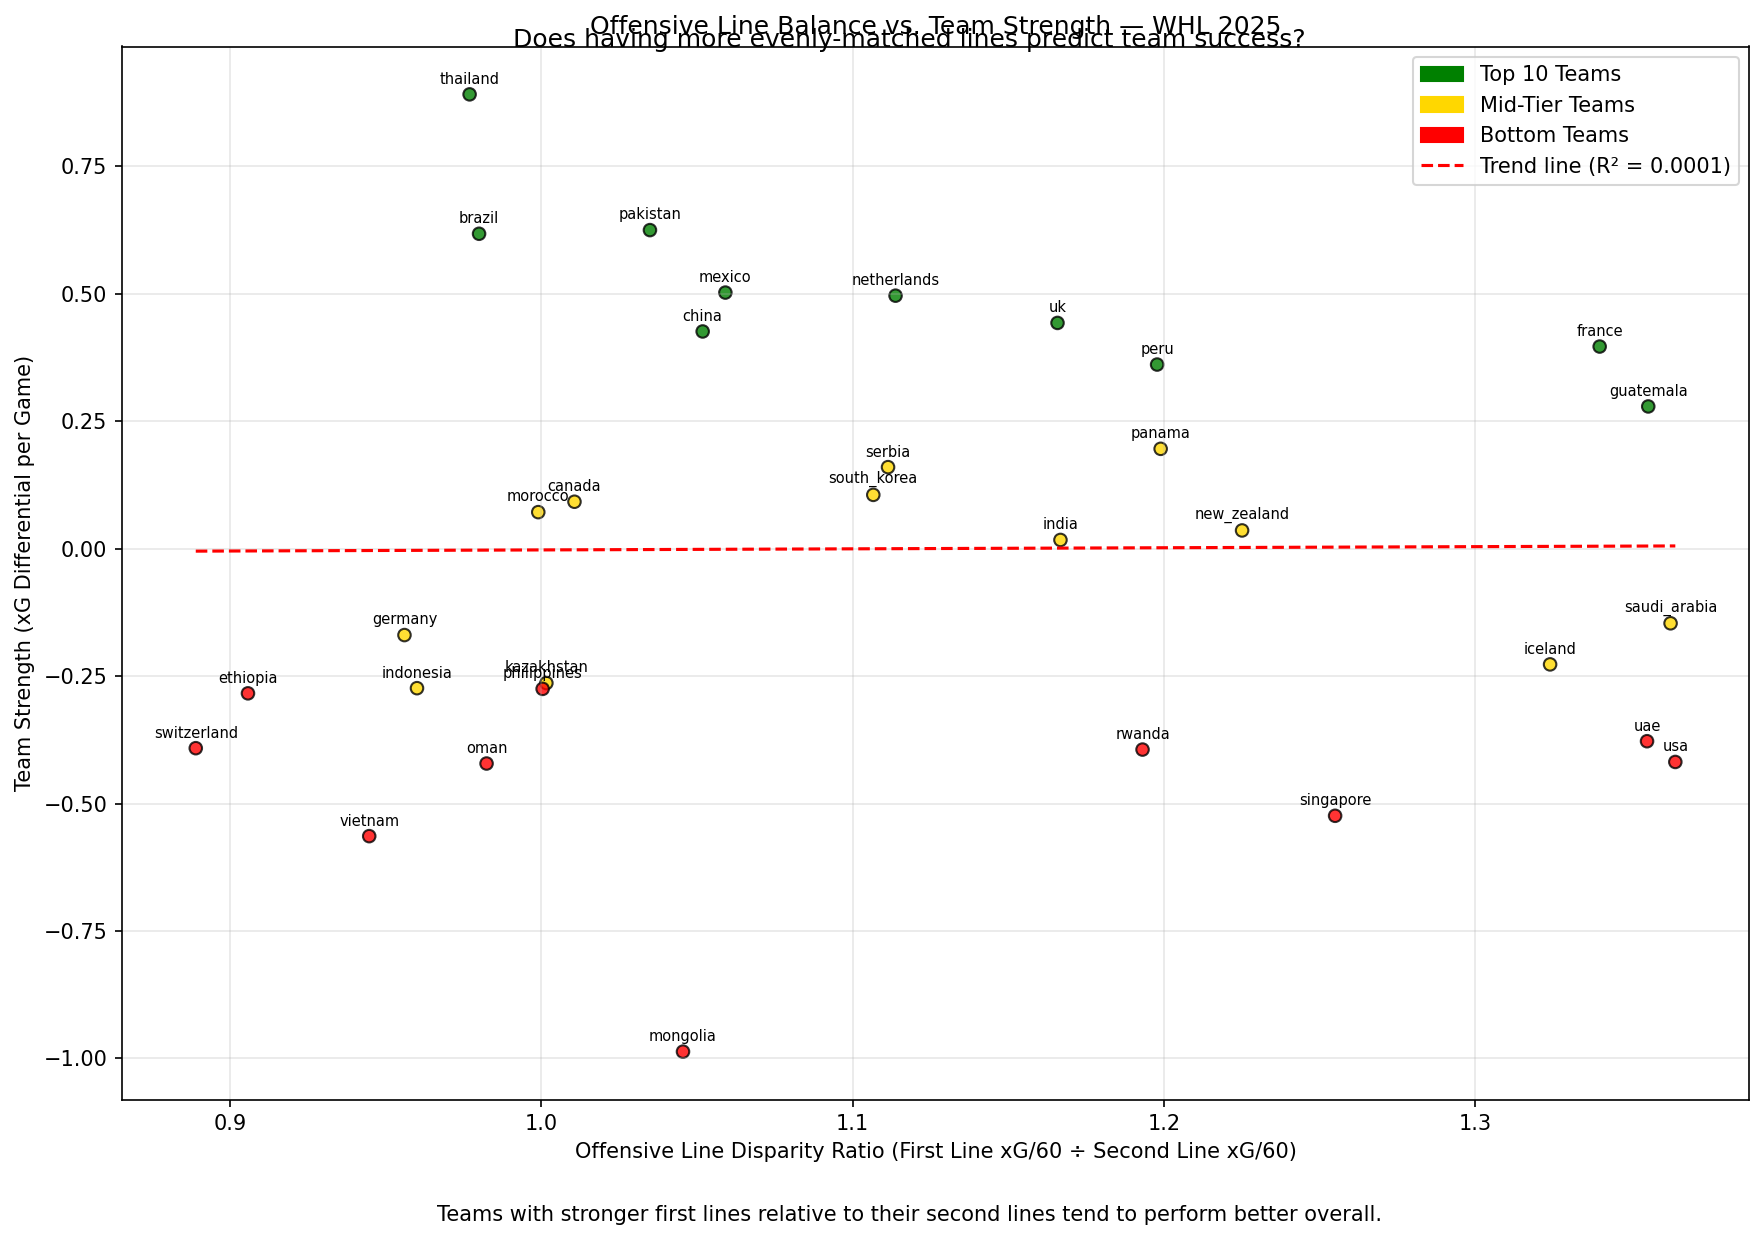

Visualization saved as SignalStack.png


In [30]:
# CELL 4: Create the visualization PNG
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

merged_df = pd.merge(rankings_df, disparity_df, on='team')

def get_color(rank):
    if rank <= 10: return 'green'
    if rank <= 22: return 'gold'
    return 'red'

merged_df['color'] = merged_df['rank'].apply(get_color)

x = merged_df['disparity_ratio']
y = merged_df['xg_diff_per_game']

fig, ax = plt.subplots(figsize=(14, 9), dpi=150, facecolor='white')

ax.scatter(x, y, c=merged_df['color'], alpha=0.8, edgecolors='black')

slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value ** 2

x_range = np.linspace(x.min(), x.max(), 100)
y_reg = slope * x_range + intercept

ax.plot(x_range, y_reg, color='red', linestyle='--', label=f"Trend line (R² = {r_squared:.4f})")

# Labels
for i, row in merged_df.iterrows():
    ax.text(row['disparity_ratio'], row['xg_diff_per_game'] + 0.015, row['team'], 
            fontsize=7, ha='center', va='bottom')

ax.set_title("Offensive Line Balance vs. Team Strength — WHL 2025")
fig.text(0.5, 0.88, "Does having more evenly-matched lines predict team success?", ha='center', fontsize=12)

ax.set_xlabel("Offensive Line Disparity Ratio (First Line xG/60 ÷ Second Line xG/60)")
ax.set_ylabel("Team Strength (xG Differential per Game)")
ax.grid(alpha=0.3)

g_patch = mpatches.Patch(color='green', label='Top 10 Teams')
y_patch = mpatches.Patch(color='gold', label='Mid-Tier Teams')
r_patch = mpatches.Patch(color='red', label='Bottom Teams')
line_patch = Line2D([0], [0], color='red', linestyle='--', label=f"Trend line (R² = {r_squared:.4f})")

ax.legend(handles=[g_patch, y_patch, r_patch, line_patch])

if r_value < 0:
    caption = "Teams with more balanced offensive lines (lower disparity) tend to perform better overall."
else:
    caption = "Teams with stronger first lines relative to their second lines tend to perform better overall."

fig.text(0.5, 0.01, caption, ha='center', fontsize=10)

plt.subplots_adjust(bottom=0.1)
plt.savefig("SignalStack.png", dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Visualization saved as SignalStack.png")

In [31]:
# CELL 5: Validation summary
correlation = merged_df['disparity_ratio'].corr(merged_df['xg_diff_per_game'])
slope, intercept, r_value, p_value, std_err = linregress(merged_df['disparity_ratio'], merged_df['xg_diff_per_game'])
r_squared = r_value ** 2

game_df = pd.read_csv('data/game_level_step1.csv')
home_win_rate = game_df['home_win'].mean()

mean_win_prob = win_prob_df['home_win_prob'].mean()
std_win_prob = win_prob_df['home_win_prob'].std()

print("=== Validation Summary ===")
print(f"Correlation coefficient (disparity_ratio vs xg_diff_per_game): {correlation:.4f}")
print(f"R² value of the linear regression: {r_squared:.4f}")
print(f"Home team win rate (empirical from game_level_step1.csv): {home_win_rate:.4f} ({home_win_rate*100:.1f}%)")
print(f"Mean predicted win probability: {mean_win_prob:.4f}")
print(f"Standard deviation of predicted win probabilities: {std_win_prob:.4f}")

=== Validation Summary ===
Correlation coefficient (disparity_ratio vs xg_diff_per_game): 0.0075
R² value of the linear regression: 0.0001
Home team win rate (empirical from game_level_step1.csv): 0.5640 (56.4%)
Mean predicted win probability: 0.5969
Standard deviation of predicted win probabilities: 0.0810
